In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import qgrid
import pybedtools as bt
import pandas as pd
import pysam
import seaborn as sns

from seaplotlib.helper import despine, save_fig_in_dir

In [2]:
# parameters
INPUT_DIRECTORY = 'Variant fragments 25 days normalized/'
INSERT_REFERENCE = 'cbergman_transposons_11_2017.fa'
IMAGE_EXTENSION = 'pdf'

In [3]:
cluster_distance = 25
input_paths = [os.path.join(INPUT_DIRECTORY, _) for _ in os.listdir(INPUT_DIRECTORY) if _.endswith('.tabular')]
sample_names = [os.path.basename(_)[:-len('.tabular')] for _ in input_paths]
# Generate a dictionary with insert name and length
ff = pysam.FastaFile(INSERT_REFERENCE)
ref_len_d = {k: v for k, v in zip(ff.references, ff.lengths)}
ref_len_d['DPSEMINIME_None_FLYBASE_FBtennnnnnn'] = ref_len_d['DPSEMINIME_None_FLYBASE:FBtennnnnnn']

In [4]:
# Read in all the summary files
dfs = []
for sample_name, input_path in zip(sample_names, input_paths):
    df = pd.read_csv(input_path, sep='\t', index_col=None)
    df['sample'] = sample_name
    dfs.append(df)
columns = list(df.columns)

In [5]:
def get_tsd_reference_start(row):
    if row['evidence_type'] == '3p_clip':
        return row['end'] - 1
    elif row['evidence_type'] == 'insert':
        return row['start'] + 1 + row['query_start']
    return 0


def get_tsd_reference_end(row):
    if row['evidence_type'] == '5p_clip':
        return row['start'] + 1
    elif row['evidence_type'] == 'insert':
        tsd_length = row['read_length'] - row['query_length'] - 2  # insertion flanked by 1N on each side
        end_shift = tsd_length - row['query_start']
        return row['end'] - 1 - end_shift 
    return 0
    


def cluster_family(included_family):
    bedtool = bt.BedTool.from_dataframe(included_family).sort().cluster(d=cluster_distance)
    df = pd.read_csv(bedtool.fn, sep='\t', header=None)
    df.columns = columns + ['cluster']
    # start/end include first/last N, so need to add/subtract 1
    df['tsd_reference_start'] = df.apply(get_tsd_reference_start, axis=1)
    df['tsd_reference_end'] = df.apply(get_tsd_reference_end, axis=1)
    # tsd_length = x.read_length - x.query_length - 2
    # # query_start is the first nucldeotide that aligns to the insert
    # # We can correct the genomic 5' of the insertion by adding the unaligned nucleotides to the start
    # x.tsd_reference_start = x.start + 1 + x.query_start
    # x.tsd_reference_end = x.end - (tsd_length - x.query_start) - 1
    df['possibly_full_length'] = df['read_length'] - df['query_length'] < 20  # read ends in insertion
    df['_insert_orientation'] = df['insert_orientation']
    g = df.groupby('cluster').aggregate(
        {'reference': max, 
         'start': min, 
         'end': max,
         'query_start': min,
         'query_end': max,
         'query_length': max,
         'read_length': max,
         'insert_reference': max,
         'insert_start': min,
         'insert_end': max,
         'evidence_type': 'unique',
         'query_name': pd.Series.nunique,
         '_insert_orientation': pd.Series.nunique,
         'insert_orientation': max,
         'sample': max,
         'tsd_reference_start': max,
         'tsd_reference_end': max,
        }
    )
    g['dist'] = g['end'] - g['start']
    g['pct_full_length'] = g.apply(lambda x: (x['insert_end'] - x['insert_start']) / ref_len_d[str(x['insert_reference'])], axis=1)
    return g.sort_values('query_length')

In [6]:
# create clusters per sample, per insert
df_l = []
for df in dfs:
    for insert_ref in df['insert_reference'].unique():
        clusters = cluster_family(df[df['insert_reference'] == insert_ref])
        df_l.append(clusters)
cluster_df = pd.concat(df_l)

# Write out clusters and annotate intersections
int_r = []
for insert_ref in cluster_df['insert_reference'].unique():
    df = cluster_df[cluster_df['insert_reference'] == insert_ref]
    columns = [i + 4 for i, _ in enumerate(df.columns[3:])]
    operations = ['first'] * len(columns)
    operations[list(df.columns).index('sample') - 3] = 'collapse'
    int_r.append(bt.BedTool.from_dataframe(df).sort().merge(c=columns, o=operations, d=10))
cluster_df = pd.concat((pd.read_csv(bedtool.fn, sep='\t', header=None) for bedtool in int_r))
cluster_df.columns = df.columns
cluster_df['n_samples'] = cluster_df['sample'].str.count(',') + 1
# Drop insertions where we're uncertain of the orientation
cluster_df = cluster_df[cluster_df['_insert_orientation'] == 1]
cluster_df = cluster_df[[c for c in cluster_df.columns if c != '_insert_orientation']]

In [7]:
# Get full length insertions with TSD
full_length_df = cluster_df[
    (cluster_df['pct_full_length'] > 0.98) &
    (cluster_df['read_length'] > 7000) &
    (cluster_df.n_samples == 1) & 
    (cluster_df.reference.isin(['X', '2L', '2R', '3L', '3R']))
]

full_length_with_tsd = full_length_df[
    (full_length_df['tsd_reference_start'] - full_length_df['tsd_reference_end'] > 0) & 
    (full_length_df['tsd_reference_start'] - full_length_df['tsd_reference_end'] < 50)
]

full_length_without_tsd = full_length_df[~full_length_df.index.isin(full_length_with_tsd.index)]

In [8]:
def cluster_to_summary(df, title='Nanopore insertions per reference with TSD'):
    df = df.groupby('sample')['insert_reference'].value_counts().to_frame()
    df.columns = ['count']
    df = df.reset_index()
    df['tissue'] = df['sample'].apply(lambda x: x.split('_')[0])
    df.to_csv(title + '.tsv', sep='\t', index=None)
    return df


def plot_summary(df, title='Full length TEs with TSD', figsize=(15, 5)):
    fig, ax= plt.subplots(figsize=figsize)
    ax = despine(sns.barplot(x='insert_reference', y='count', hue='tissue', data=df, ax=ax, palette=['black', 'lightgray']))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    fig.suptitle(title)
    save_fig_in_dir(ax.figure, '%s.%s' % (title, IMAGE_EXTENSION), directory=INPUT_DIRECTORY, bbox_inches='tight')

In [9]:
insert_full_length_per_sample = cluster_to_summary(full_length_df, title='Nanopore insert per reference')
insert_full_length_per_sample

,sample,insert_reference,count,tissue
0,Guts_D25_P1,rover,86,Guts
1,Guts_D25_P1,roo,16,Guts
2,Guts_D25_P1,springer,12,Guts
3,Guts_D25_P1,Doc,9,Guts
4,Guts_D25_P1,copia,8,Guts
...,...,...,...,...
228,Heads_D25_P2,diver2,1,Heads
229,Heads_D25_P2,gypsy,1,Heads
230,Heads_D25_P2,invader6,1,Heads
231,Heads_D25_P2,springer,1,Heads


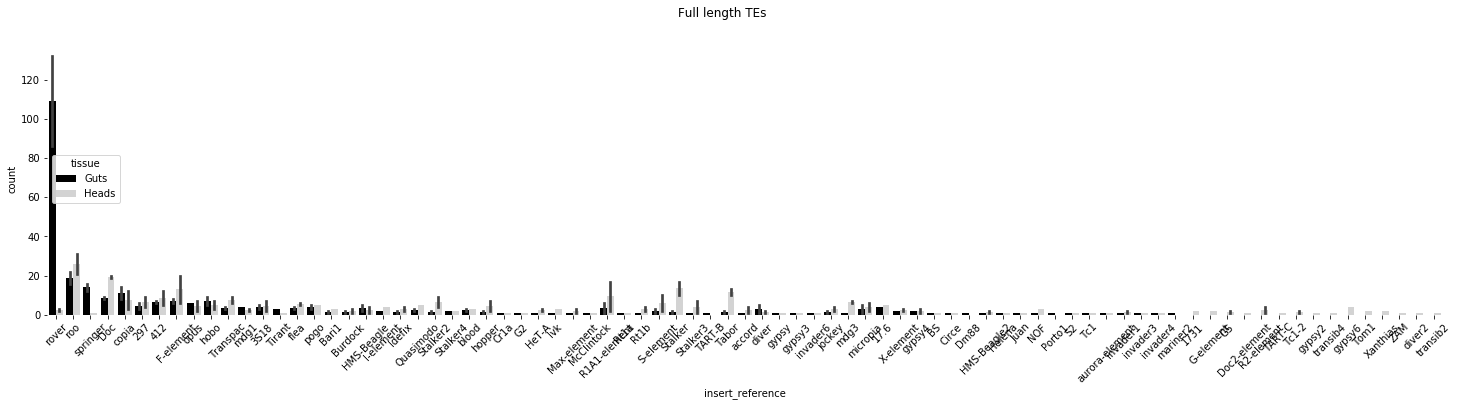

In [10]:
plot_summary(insert_full_length_per_sample, title='Full length TEs', figsize=(25, 5))

In [11]:
full_length_with_tsd

,reference,start,end,query_start,query_end,query_length,read_length,insert_reference,insert_start,insert_end,evidence_type,query_name,insert_orientation,sample,tsd_reference_start,tsd_reference_end,dist,pct_full_length,n_samples
933,3R,11656649,11656655,0,7148,6552,7158,17.6,0,7428,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,11656654,11656650,6,0.998521,1
311,2L,4280224,4280226,2,7460,7458,7499,roo,27,9091,['insert'],1,-,Heads_D25_P2,4280227,4280188,2,0.996920,1
538,2L,8080254,8080257,0,17736,7809,17759,roo,15,9092,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,8080256,8080255,3,0.998350,1
1454,2R,3149400,3149406,0,19025,8736,19026,roo,0,9092,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,3149405,3149401,6,1.000000,1
2178,2R,18038845,18038850,4,13685,4566,13688,roo,6,9088,['5p_clip' '3p_clip'],1,-,Heads_D25_P2,18038849,18038846,5,0.998900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2R,6885359,6885363,0,7015,4883,9056,flea,9,5033,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,6885362,6885360,4,0.998014,1
731,X,16563753,16563758,0,17939,4924,17940,flea,0,5034,['5p_clip' '3p_clip'],1,-,Heads_D25_P1,16563757,16563754,5,1.000000,1
369,X,23281167,23281172,0,17077,1960,17078,gypsy2,0,6841,['5p_clip' '3p_clip'],4,+,Heads_D25_P1,23281171,23281168,5,1.000000,1
910,X,13377303,13377307,10,13761,5252,13771,I-element,3,5359,['5p_clip' '3p_clip'],1,+,Guts_D25_P2,13377306,13377304,4,0.997207,1


In [12]:
full_length_without_tsd_per_sample = cluster_to_summary(full_length_without_tsd, title='Nanopore insert per reference')
full_length_without_tsd_per_sample

,sample,insert_reference,count,tissue
0,Guts_D25_P1,rover,26,Guts
1,Guts_D25_P1,roo,15,Guts
2,Guts_D25_P1,Doc,8,Guts
3,Guts_D25_P1,297,6,Guts
4,Guts_D25_P1,412,6,Guts
...,...,...,...,...
216,Heads_D25_P2,diver2,1,Heads
217,Heads_D25_P2,gypsy,1,Heads
218,Heads_D25_P2,jockey,1,Heads
219,Heads_D25_P2,springer,1,Heads


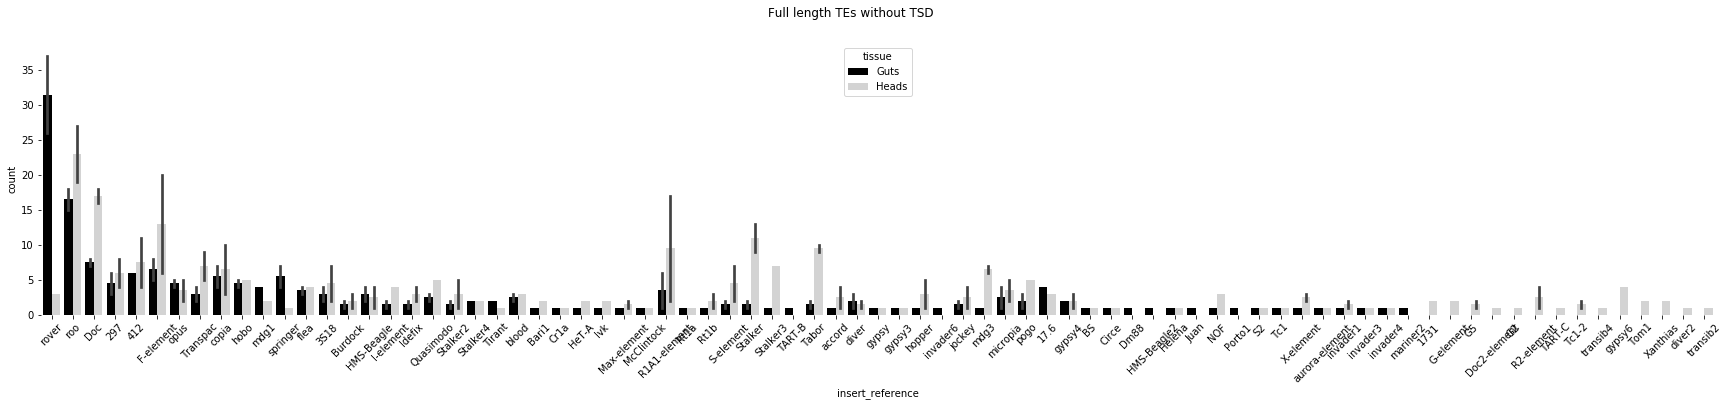

In [13]:
plot_summary(full_length_without_tsd_per_sample, title='Full length TEs without TSD', figsize=(30, 5))

In [14]:
insert_full_length_with_tsd_per_sample = cluster_to_summary(full_length_with_tsd)
insert_full_length_with_tsd_per_sample

,sample,insert_reference,count,tissue
0,Guts_D25_P1,rover,60,Guts
1,Guts_D25_P1,springer,8,Guts
2,Guts_D25_P1,copia,3,Guts
3,Guts_D25_P1,Bari1,1,Guts
4,Guts_D25_P1,hobo,1,Guts
5,Guts_D25_P1,roo,1,Guts
6,Guts_D25_P2,rover,92,Guts
7,Guts_D25_P2,springer,8,Guts
8,Guts_D25_P2,copia,5,Guts
9,Guts_D25_P2,hobo,4,Guts


In [15]:
full_length_with_tsd.to_csv('All full length insertions with TSD locations' + '.tsv', sep='\t', index=None)

In [16]:
full_length_with_tsd

,reference,start,end,query_start,query_end,query_length,read_length,insert_reference,insert_start,insert_end,evidence_type,query_name,insert_orientation,sample,tsd_reference_start,tsd_reference_end,dist,pct_full_length,n_samples
933,3R,11656649,11656655,0,7148,6552,7158,17.6,0,7428,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,11656654,11656650,6,0.998521,1
311,2L,4280224,4280226,2,7460,7458,7499,roo,27,9091,['insert'],1,-,Heads_D25_P2,4280227,4280188,2,0.996920,1
538,2L,8080254,8080257,0,17736,7809,17759,roo,15,9092,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,8080256,8080255,3,0.998350,1
1454,2R,3149400,3149406,0,19025,8736,19026,roo,0,9092,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,3149405,3149401,6,1.000000,1
2178,2R,18038845,18038850,4,13685,4566,13688,roo,6,9088,['5p_clip' '3p_clip'],1,-,Heads_D25_P2,18038849,18038846,5,0.998900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2R,6885359,6885363,0,7015,4883,9056,flea,9,5033,['5p_clip' '3p_clip'],1,+,Heads_D25_P2,6885362,6885360,4,0.998014,1
731,X,16563753,16563758,0,17939,4924,17940,flea,0,5034,['5p_clip' '3p_clip'],1,-,Heads_D25_P1,16563757,16563754,5,1.000000,1
369,X,23281167,23281172,0,17077,1960,17078,gypsy2,0,6841,['5p_clip' '3p_clip'],4,+,Heads_D25_P1,23281171,23281168,5,1.000000,1
910,X,13377303,13377307,10,13761,5252,13771,I-element,3,5359,['5p_clip' '3p_clip'],1,+,Guts_D25_P2,13377306,13377304,4,0.997207,1


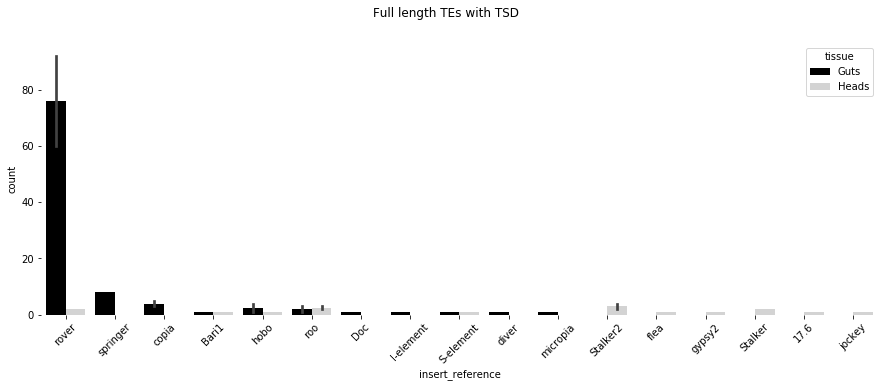

In [17]:
plot_summary(insert_full_length_with_tsd_per_sample)

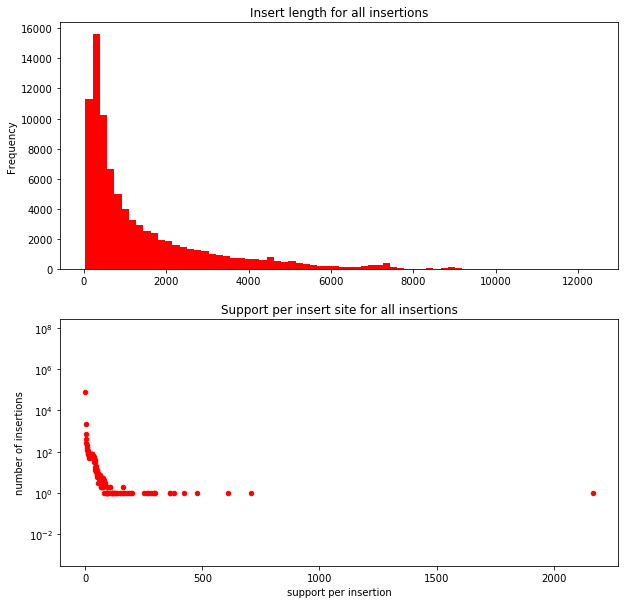

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
# fig.canvas.layout.width = '100%'
# fig.canvas.layout.height = '900px'

qgrid_widget = qgrid.show_grid(cluster_df, show_toolbar=True)
df = qgrid_widget.get_changed_df()
default_title = "Insert length for all insertions"

def plot_length(df):
    axes[0].clear()
    insert_refs = df['insert_reference'].unique()
    if len(insert_refs) == 1:
        title = "Insert length for %s insertions" % insert_refs[0]
    else:
        title = default_title
    axes[0].set_title(title)
    df['query_length'].plot(kind='hist',
                            bins=70, 
                            ax=axes[0],
                            color='r',
                           )
    fig.canvas.draw()
    
    
def plot_support_per_insertion(df):
    axes[1].clear()
    insert_refs = df['insert_reference'].unique()
    if len(insert_refs) == 1:
        title = "Support per insert site for %s insertions" % insert_refs[0]
    else:
        title = "Support per insert site for all insertions"
    axes[1].set_title(title)
    r = df.query_name.value_counts().to_frame()
    r = r.rename(columns={'query_name': 'number of insertions'})
    r['support per insertion'] = r.index
    r = r.sort_values('support per insertion')
    r.plot(x='support per insertion', 
           y='number of insertions', 
           kind='scatter', 
           logy=True, 
           ax=axes[1],
           color='r'
          )
    fig.canvas.draw()

def handle_filter_changed(event, widget):
    qgrid_df = widget.get_changed_df()
    plot_length(qgrid_df)
    plot_support_per_insertion(qgrid_df)
    
plot_length(df)
plot_support_per_insertion(df)
qgrid_widget.on('filter_changed', handle_filter_changed)

In [19]:
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [20]:
save_fig_in_dir(fig, 'Long insertions overview.%s' % IMAGE_EXTENSION, directory=INPUT_DIRECTORY, bbox_inches='tight')

In [22]:
insert_full_length_with_tsd_per_sample.to_csv(os.path.join(INPUT_DIRECTORY, 'Full_length_with_tsd_summary.tsv'), sep='\t')

In [23]:
BED_COLUMNS = ['reference', 'tsd_reference_end', 'tsd_reference_start', 'insert_reference', 'score', 'insert_orientation', 'sample']
subset = full_length_with_tsd
subset['score'] = 1
subset = subset[BED_COLUMNS]
bt.BedTool.from_dataframe(subset).saveas(os.path.join(INPUT_DIRECTORY, 'all_singletons_with_tsd.bed'))

/Users/mvandenb/miniconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<BedTool(Variant fragments 25 days normalized/all_singletons_with_tsd.bed)>

In [24]:
rover_with_tsd = full_length_with_tsd[full_length_with_tsd['insert_reference'] == 'rover']
rover_with_tsd

,reference,start,end,query_start,query_end,query_length,read_length,insert_reference,insert_start,insert_end,evidence_type,query_name,insert_orientation,sample,tsd_reference_start,tsd_reference_end,dist,pct_full_length,n_samples,score
36,2L,1118019,1118035,6,32730,7353,32731,rover,0,7318,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,1118034,1118020,16,1.000000,1,1
41,2L,1721546,1721553,0,10137,7282,20930,rover,0,7318,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,1721552,1721547,7,1.000000,1,1
76,2L,4366016,4366024,0,9733,7367,13177,rover,0,7318,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,4366023,4366017,8,1.000000,1,1
79,2L,5007164,5007166,3,7202,7199,7206,rover,0,7313,['insert'],1,+,Guts_D25_P1,5007168,5007163,2,0.999317,1,1
89,2L,6258819,6258821,2,7419,7417,7423,rover,0,7318,['insert'],1,+,Guts_D25_P2,6258822,6258818,2,1.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,X,19714017,19714024,0,10524,7453,10531,rover,6,7318,['5p_clip' '3p_clip'],1,-,Guts_D25_P2,19714023,19714018,7,0.999180,1,1
1674,X,21292648,21292655,1,9397,7314,34710,rover,0,7315,['5p_clip' '3p_clip'],1,-,Guts_D25_P1,21292654,21292649,7,0.999590,1,1
1677,X,21330150,21330152,5,7395,7390,7397,rover,0,7317,['insert'],1,+,Guts_D25_P2,21330156,21330151,2,0.999863,1,1
1681,X,21561161,21561163,6,7392,7386,7394,rover,0,7317,['insert'],1,+,Guts_D25_P2,21561168,21561162,2,0.999863,1,1
